Train Score: 0.14 RMSE
Test Score: 0.20 RMSE
Train Score: 0.981946473241978 R2
Test Score: 0.7536084832852519 R2
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


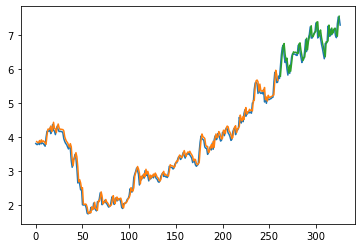

In [15]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import LSTM
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('Cemex.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(trainX, trainY, epochs=500, batch_size=10, verbose=0)
plot_model(model,to_file="model2.png",show_shapes=True,show_layer_names=True,dpi=96)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(metrics.mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(metrics.mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
r2_train = metrics.r2_score(trainY[0], trainPredict[:,0])
print("Train Score: {} R2".format(r2_train))
r2_test = metrics.r2_score(testY[0], testPredict[:,0])
print("Test Score: {} R2".format(r2_test))
model.summary()
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [16]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)

NameError: name 'all_data' is not defined